In [29]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn import linear_model 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
%matplotlib inline

In [30]:
data = pd.read_csv(r"C:\Data_sets\retail.csv")

C:\Users\DS\AppData\Local\Temp\ipykernel_14520\3970298050.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(r"C:\Data_sets\retail.csv")


## Знакомство с датасетом и просмотр нулевых значений, а также дубликатов

In [31]:
data.head()

,Unnamed: 0.1,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Shop
0,0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,Shop1
1,1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,Shop2
2,2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,online_shop
3,3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,Shop4
4,4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,Shop5


In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0.1  525461 non-null  int64  
 1   Unnamed: 0    525461 non-null  int64  
 2   Invoice       525461 non-null  object 
 3   StockCode     525461 non-null  object 
 4   Description   522533 non-null  object 
 5   Quantity      525461 non-null  int64  
 6   InvoiceDate   525461 non-null  object 
 7   Price         525461 non-null  float64
 8   Customer ID   417534 non-null  float64
 9   Shop          40 non-null      object 
dtypes: float64(2), int64(3), object(5)
memory usage: 40.1+ MB


In [33]:
data.describe(include='object')

,Invoice,StockCode,Description,InvoiceDate,Shop
count,525461,525461,522533,525461,40
unique,28816,4632,4681,25296,40
top,537434,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2010-12-06 16:57:00,Shop1
freq,675,3516,3549,675,1


In [34]:
data.isna().sum()

Unnamed: 0.1         0
Unnamed: 0           0
Invoice              0
StockCode            0
Description       2928
Quantity             0
InvoiceDate          0
Price                0
Customer ID     107927
Shop            525421
dtype: int64

In [35]:
data[data.duplicated()].shape[0]

0

In [36]:
# Преобразуем идентификатор клиента в числовой формат
data['Customer ID'] = data['Customer ID'].astype(float)

# Узнаем в каком временном интервале проводились транзакции
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

print('Date interval {} to {}'.format(data['InvoiceDate'].dt.date.min(), 
                                      data['InvoiceDate'].dt.date.max()))

Date interval 2009-12-01 to 2010-12-09


Датасет собран за год работы магазина.

## Преобразуем и очистим данные

**1.Пропуски**

In [37]:
notnull_rows = data['Customer ID'].notnull()
data = data[notnull_rows]

print(data.isna().sum(), '\n')
print(data.shape)

Unnamed: 0.1         0
Unnamed: 0           0
Invoice              0
StockCode            0
Description          0
Quantity             0
InvoiceDate          0
Price                0
Customer ID          0
Shop            417494
dtype: int64 

(417534, 10)


**2.Дубликаты. Удаление.**

In [38]:
data.drop_duplicates(inplace=True)

print(data.duplicated().sum(), '\n')
print(data.shape)

0 

(417534, 10)


**3. Учет возвратов**

Очевидно, что возвраты нужно учитывать при сегментировании покупателей в разрезе RFM. Это влияет на их покупательскую способность.

In [39]:
temp = data.groupby(by=['Customer ID', 'Invoice'], as_index=False)['InvoiceDate'].count()

nb_products_per_basket = temp.rename(columns={'InvoiceDate': 'Number of products'})

nb_products_per_basket

,Customer ID,Invoice,Number of products
0,12346.0,491725,1
1,12346.0,491742,1
2,12346.0,491744,1
3,12346.0,492718,1
4,12346.0,492722,1
...,...,...,...
23582,18287.0,508581,54
23583,18287.0,523289,19
23584,18287.0,523290,2
23585,18287.0,534346,10


**Достаточно много продуктов являются возвратными.**

Создадим признак - флаг для идентификации возвратов для каждого товара. Данный признак сыграет, если найдется противоположенная транзакция с возвратом.

In [40]:
def get_qw(data: pd.DataFrame) -> pd.Series:
    """Функция для создания признака количества отменённых заказов. 
    Функция принимает на вход таблицу и возвращает столбец, в котором указано 
    количество отменённого впоследствии товара для кажой транзакции.
    Если транзакция c отрицательным количеством товара не имеет контрагента, 
    данный признак помечается как NaN.

    Args:
    -
        data (DataFrame): таблица c транзакциями

    Returns:
    -
        Series: столбец c количеством отменённого товара
    """
    
    
    qw = pd.Series(np.zeros(data.shape[0]), index=data.index)    
    
    negative_quantity = data[(data['Quantity'] < 0)].copy()
    
    for index, col in negative_quantity.iterrows():
        # Создаём DataFrame из всех контрагентов
        df_test = data[(data['Customer ID'] == col['Customer ID']) &
                       (data['StockCode']  == col['StockCode']) & 
                       (data['InvoiceDate'] < col['InvoiceDate']) & 
                       (data['Quantity'] > 0)].copy()
        
        
        if df_test.shape[0] == 0: 
            qw.loc[index] = np.nan
            

        elif df_test.shape[0] == 1: 
            index_order = df_test.index[0]
            qw.loc[index_order] = -col['Quantity'] 
                  
    
        else: 
            df_test.sort_index(axis=0, 
                               ascending=False, 
                               inplace=True)  
                  
            for i, val in df_test.iterrows():
                if val['Quantity'] < -col['Quantity']: 
                    continue
                qw.loc[i] = -col['Quantity']
                break         
            
    return qw


data['QuantityCanceled'] = get_qw(data)

data

,Unnamed: 0.1,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Shop,QuantityCanceled
0,0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,Shop1,0.0
1,1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,Shop2,0.0
2,2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,online_shop,0.0
3,3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,Shop4,0.0
4,4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,Shop5,0.0
...,...,...,...,...,...,...,...,...,...,...,...
525456,525456,525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,NaN,0.0
525457,525457,525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,NaN,0.0
525458,525458,525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,NaN,0.0
525459,525459,525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,NaN,0.0


Удалили транзакции, которые не имеют контрагентов. Также нет больше необходимости держать транзакции с отрицательным количеством товаров.

In [41]:
data = data[data['QuantityCanceled'].notnull()]

data.query('Quantity >= 0', inplace=True)

data.shape


C:\Users\DS\AppData\Local\Temp\ipykernel_14520\2269738282.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.query('Quantity >= 0', inplace=True)


(407695, 11)

Спец транзакции не характеризуют покупательную способность покупателя. Они начинаются с латинских букв. Можно удалить их.

In [42]:
spec_operations = data['StockCode'].apply(lambda x: x[0].isalpha())
spec_rows = data[spec_operations].index

data.drop(spec_rows, axis=0, inplace=True)

data.shape

C:\Users\DS\AppData\Local\Temp\ipykernel_14520\3247007653.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop(spec_rows, axis=0, inplace=True)


(406323, 11)

Удалим транзакции без цены.

In [43]:
data.query('Price != 0', inplace=True)

C:\Users\DS\AppData\Local\Temp\ipykernel_14520\106667226.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.query('Price != 0', inplace=True)


**Насколько часто покупает покупатель?**

Очень важно понимать, какие покупатели являются частыми. Создадим признак, который сигнализирует о том, частый ли клиент.

In [44]:
cust_vc = data['Customer ID'].value_counts()
cust_frequent = cust_vc[cust_vc >= 500].index.tolist()

data['IsFrequentCustomer'] = data['Customer ID'].apply(lambda x: 1 if x in cust_frequent else 0)

data.head()

C:\Users\DS\AppData\Local\Temp\ipykernel_14520\3972201857.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IsFrequentCustomer'] = data['Customer ID'].apply(lambda x: 1 if x in cust_frequent else 0)


,Unnamed: 0.1,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Shop,QuantityCanceled,IsFrequentCustomer
0,0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,Shop1,0.0,0
1,1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,Shop2,0.0,0
2,2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,online_shop,0.0,0
3,3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,Shop4,0.0,0
4,4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,Shop5,0.0,0


**Признак даты и времени**

In [45]:
data['Month'] = data['InvoiceDate'].dt.month
data['Day'] = data['InvoiceDate'].dt.day
data['DayOfWeek'] = data['InvoiceDate'].dt.dayofweek

data.head()

C:\Users\DS\AppData\Local\Temp\ipykernel_14520\2338220310.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Month'] = data['InvoiceDate'].dt.month
C:\Users\DS\AppData\Local\Temp\ipykernel_14520\2338220310.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Day'] = data['InvoiceDate'].dt.day
C:\Users\DS\AppData\Local\Temp\ipykernel_14520\2338220310.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

,Unnamed: 0.1,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Shop,QuantityCanceled,IsFrequentCustomer,Month,Day,DayOfWeek
0,0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,Shop1,0.0,0,12,1,1
1,1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,Shop2,0.0,0,12,1,1
2,2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,online_shop,0.0,0,12,1,1
3,3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,Shop4,0.0,0,12,1,1
4,4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,Shop5,0.0,0,12,1,1


**Обработка названий товаров**

Создадим признак- флаг, покупает ли покупатель самые частые товары.

In [46]:
descr_vc = data['Description'].value_counts()
descr_freq = descr_vc[descr_vc >= 500].index.tolist()

catset = set()

for cat in descr_freq:
    cats = cat.split()
    for c in cats:
        catset.add(c)
        
catlist = list(filter(lambda x: True if ((x.isalpha()) and (len(x) > 2)) else False, 
                      catset))

# Первые 20 элементов списка
catlist[:20]

['EDWARDIAN',
 'PARASOL',
 'WHITE',
 'LADIES',
 'CERAMIC',
 'DOVE',
 'RECYCLING',
 'TRELLIS',
 'WOODLAND',
 'NIGHT',
 'PACK',
 'CHARLOTTE',
 'TAILS',
 'HANGER',
 'JEWELLERY',
 'BOXES',
 'BAG',
 'RECIPE',
 'POPCORN',
 'FRUITS']

In [47]:
# Пройдемся по столбцу с названиями товаров с помощью функции,
# которая проверяет, есть ли в них слова из списка с категориями.

def catbin(x):
    for cat in x.split():
        if cat in catlist:
            return 1
        else:
            return 0

data['IsFrequentStock'] = data['Description'].apply(catbin)

data.head()

C:\Users\DS\AppData\Local\Temp\ipykernel_14520\1808983338.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['IsFrequentStock'] = data['Description'].apply(catbin)


,Unnamed: 0.1,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Shop,QuantityCanceled,IsFrequentCustomer,Month,Day,DayOfWeek,IsFrequentStock
0,0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,Shop1,0.0,0,12,1,1,0
1,1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,Shop2,0.0,0,12,1,1,1
2,2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,online_shop,0.0,0,12,1,1,1
3,3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,Shop4,0.0,0,12,1,1,0
4,4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,Shop5,0.0,0,12,1,1,1


In [48]:
# Сбросим индексы, чтобы нумерация строк была по порядку
data.reset_index(drop=True, inplace=True)

**Построение RFM-таблицы**

Добавим в ваш датасет общую цену заказа (TotalPrice). Она рассчитывается как:

общая цена = цена за единицу товара * (количество товаров в заказе - количество возвращённых товаров).

In [50]:
data['TotalPrice'] = data['Price'] * (data['Quantity'] - data['QuantityCanceled'])

data.head()

C:\Users\DS\AppData\Local\Temp\ipykernel_14520\1742647444.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalPrice'] = data['Price'] * (data['Quantity'] - data['QuantityCanceled'])


,Unnamed: 0.1,Unnamed: 0,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Shop,QuantityCanceled,IsFrequentCustomer,Month,Day,DayOfWeek,IsFrequentStock,TotalPrice
0,0,0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,Shop1,0.0,0,12,1,1,0,83.4
1,1,1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,Shop2,0.0,0,12,1,1,1,81.0
2,2,2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,online_shop,0.0,0,12,1,1,1,81.0
3,3,3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,Shop4,0.0,0,12,1,1,0,100.8
4,4,4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,Shop5,0.0,0,12,1,1,1,30.0


* Recency для i-го клиента рассчитывается как разница между датой и временем последнего заказа и точкой отсчёта.
* Frequency рассчитывается как общее количество уникальных заказов, которые совершил i-ый клиент.
* Monetary Value рассчитывается как общая сумма денег, которую i-ый клиент потратил на наши товары (с учётом возвратов).

In [51]:
t0 = pd.to_datetime('2011-12-10 00:00:00')
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


# Группировка данных по идентификатору клиента
recency = data.groupby('Customer ID', as_index=False)['InvoiceDate'].last()
recency['InvoiceDate'] = (t0 - recency['InvoiceDate']).dt.days

frequency = data.groupby('Customer ID', as_index=False)['InvoiceDate'].count()

monetary_value = data.groupby('Customer ID', as_index=False)['TotalPrice'].sum()


# Соединение получившихся таблиц в одну
RFM_data = recency.rename(columns={'InvoiceDate': 'Recency'})

RFM_data = RFM_data.merge(frequency, 
                          on='Customer ID',
                          how='left').rename(columns={'InvoiceDate': 'Frequency'})

RFM_data = RFM_data.merge(monetary_value, 
                          on='Customer ID', 
                          how='left').rename(columns={'TotalPrice': 'MonetaryValue'})

C:\Users\DS\AppData\Local\Temp\ipykernel_14520\905842897.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])


Посмотрим на наши выбросы

<Axes: xlabel='MonetaryValue'>

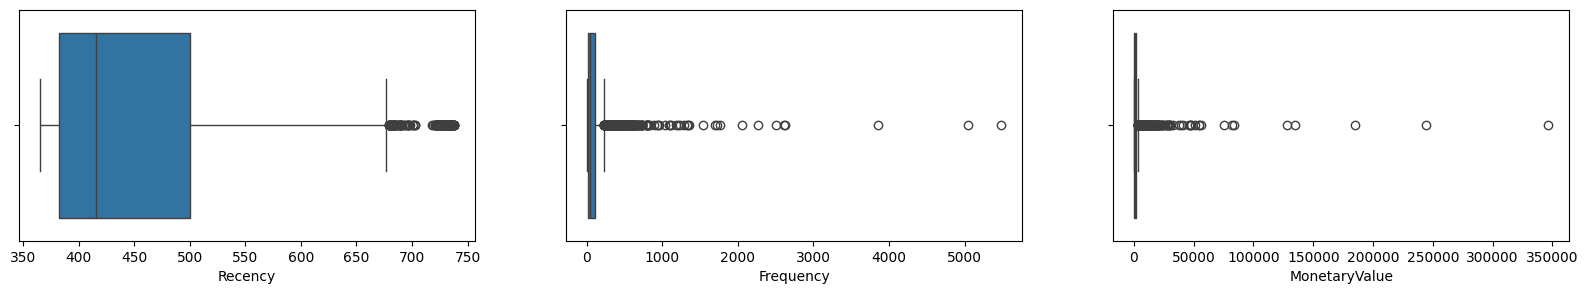

In [52]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))

sns.boxplot(RFM_data, x='Recency', ax=ax[0])
sns.boxplot(RFM_data, x='Frequency', ax=ax[1])
sns.boxplot(RFM_data, x='MonetaryValue', ax=ax[2]) 

Видим, что выбрососы есть и это может сказаться плохо при работе с кластеризацией k-means. Удаляем по квантилю 95.

<Axes: xlabel='MonetaryValue'>

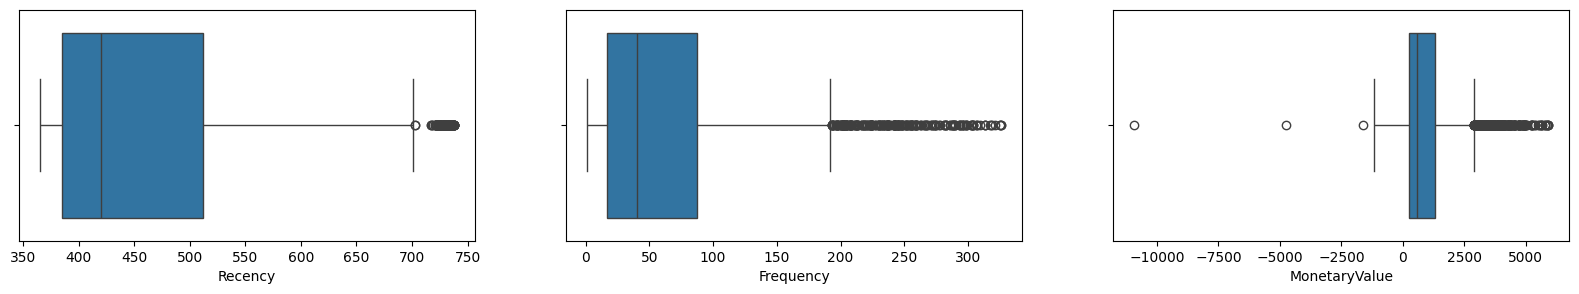

In [108]:
freq_95 = RFM_data['Frequency'].quantile(0.95)
monv_95 = RFM_data['MonetaryValue'].quantile(0.95)

RFM_data = RFM_data[(RFM_data['Frequency'] <= freq_95) & 
                    (RFM_data['MonetaryValue'] <= monv_95)]

fig, ax = plt.subplots(1, 3, figsize=(20, 3))

sns.boxplot(RFM_data, x='Recency', ax=ax[0])
sns.boxplot(RFM_data, x='Frequency', ax=ax[1])
sns.boxplot(RFM_data, x='MonetaryValue', ax=ax[2])

Я так думаю, стало гораздо лучше.

## Кластеризация

Первое, что сделам, это стандартизация.  И создание специальной таблицы на основе этих признаков. Количество кластеров здесь проверяется методом силуэта.

In [53]:
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score


In [116]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

cols = ['Recency', 'Frequency', 'MonetaryValue']

RFM_std = RFM_data[cols].copy()
RFM_std = scaler.fit_transform(RFM_data[cols])



Функция, подбирающая различные значения кластеров в зависимости от метода силуэта.

In [118]:
def clustering_optimisation(X, algorithm, RS=42, plot=False):
    """Функция подбирает различные значения количества кластеров для
    указанного алгоритма кластеризации, производит подсчет 
    коэффициента силуэта, заносит в соответствующий словарь пару 
    "число кластеров - значение коэффициента", и возвращает либо график
    изменения КС в зависимости от числа кластеров, либо сам словарь.
    
    Args:
    -
        X (DataFrame): данные для подбора количества кластеров \n
        algorithm (str): алгоритм кластеризации \n
        RS (int): параметр для `random_state` \n
        plot (bool): возвращать ли график, если нет - вернуть словарь
    """
    
    scores = {}
    
    for i in range(3, 11):
        if algorithm == 'kmeans':
            model = KMeans(n_clusters=i, n_init=10, random_state=RS)
        elif algorithm == 'agglomerative':
            model = AgglomerativeClustering(n_clusters=i)
        elif algorithm == 'EM':
            model = GaussianMixture(n_components=i, random_state=RS)
        
        y = model.fit_predict(X)
        
        scores[i] = silhouette_score(X, y, random_state=RS)
        
    if plot:
        plt.xlabel("cluster", fontsize=12)
        plt.ylabel("silhouette", fontsize=12)
        plt.title(f"silhouette_score: {algorithm}", fontsize=12)

        plt.plot(list(scores.keys()), 
                 list(scores.values()), 
                 'xb-')
    else:
        return scores

## Иерерархическая кластеризация

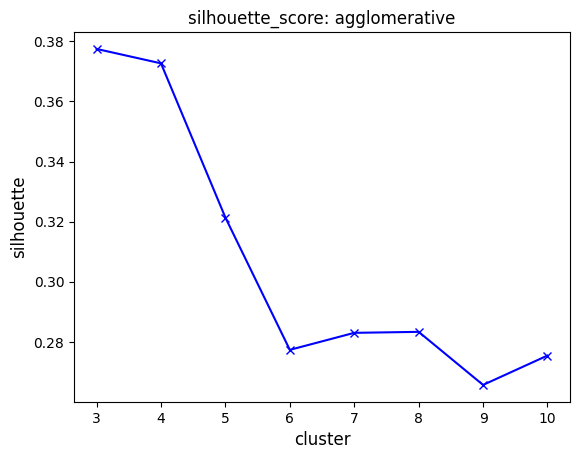

In [119]:
clustering_optimisation(RFM_std, 'agglomerative', plot=True)

## KMeans

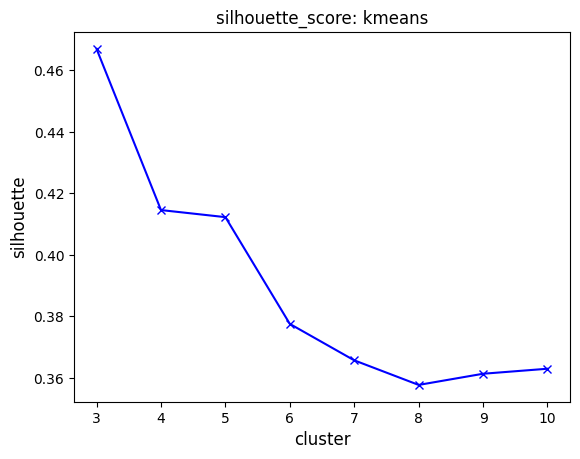

In [121]:
clustering_optimisation(RFM_std, 'kmeans', plot=True)

## EM-кластеризация

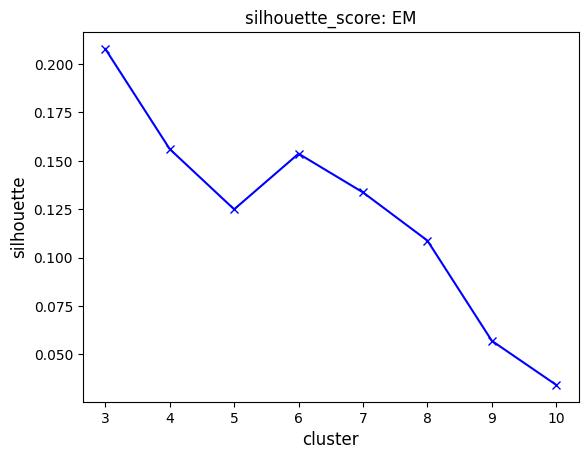

In [123]:
clustering_optimisation(RFM_std, 'EM', plot=True)

## DBSCAN

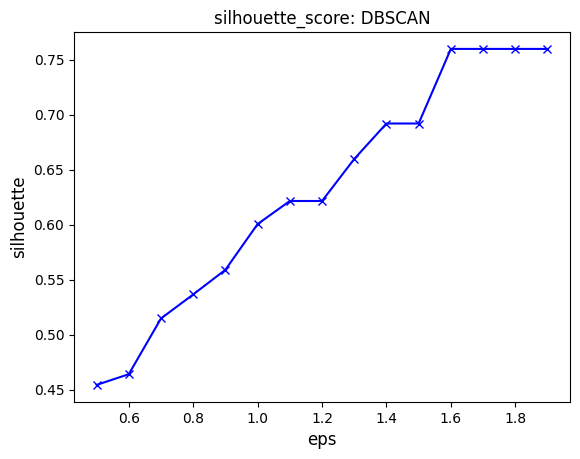

In [124]:
scores = {}

for i in np.arange(0.5, 2, 0.1):
    model = DBSCAN(eps=i)
    y = model.fit_predict(RFM_std)
    
    scores[i] = silhouette_score(RFM_std, y, random_state=42)
    

plt.xlabel("eps", fontsize=12)
plt.ylabel("silhouette", fontsize=12)
plt.title("silhouette_score: DBSCAN", fontsize=12)

plt.plot(list(scores.keys()), 
            list(scores.values()), 
            'xb-')

In [125]:
model = DBSCAN(eps=1.4)
RFM_data['Label_DBSCAN'] = model.fit_predict(RFM_std) + 1

RFM_data['Label_DBSCAN'].unique()

array([1, 0], dtype=int64)

In [126]:
model = KMeans(n_clusters=3, n_init=10, random_state=42)
RFM_data['Label_KMeans'] = model.fit_predict(RFM_std)

## Визуализация кластеров

In [127]:
def make_scatter3d(data, labels):
    """Функция создает трехмерную точечную диаграмму, 
    окрашенную в зависимости от целевой переменной.
    
    Args:
    -
        data (DataFrame): таблица c данными - X \n
        labels (Series): целевой признак - y
    
    """
    
    fig = plt.figure(figsize=(15, 10))
    ax = fig.add_subplot(projection='3d') 
    
    # Название целевого признака
    y = 'Label_' + labels
    
    # Создаем трехмерную точечную диаграмму
    scat = ax.scatter(xs=data['Recency'], 
                      ys=data['Frequency'], 
                      zs=data['MonetaryValue'], 
                      c=data[y])
    
    # Названия осей и самого графика
    ax.set_xlabel('Recency')
    ax.set_ylabel('Frequency')
    ax.set_zlabel('MonetaryValue')
    ax.set_title(f'Распределение кластеров в трехмерном пространстве ({labels})')

    # Легенда
    legend = ax.legend(scat.legend_elements()[0], 
                    [0, 1, 2], 
                    title="Label", 
                    loc='upper right')
    ax.add_artist(legend)

    fig.show()

C:\Users\DS\AppData\Local\Temp\ipykernel_18688\1759681457.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


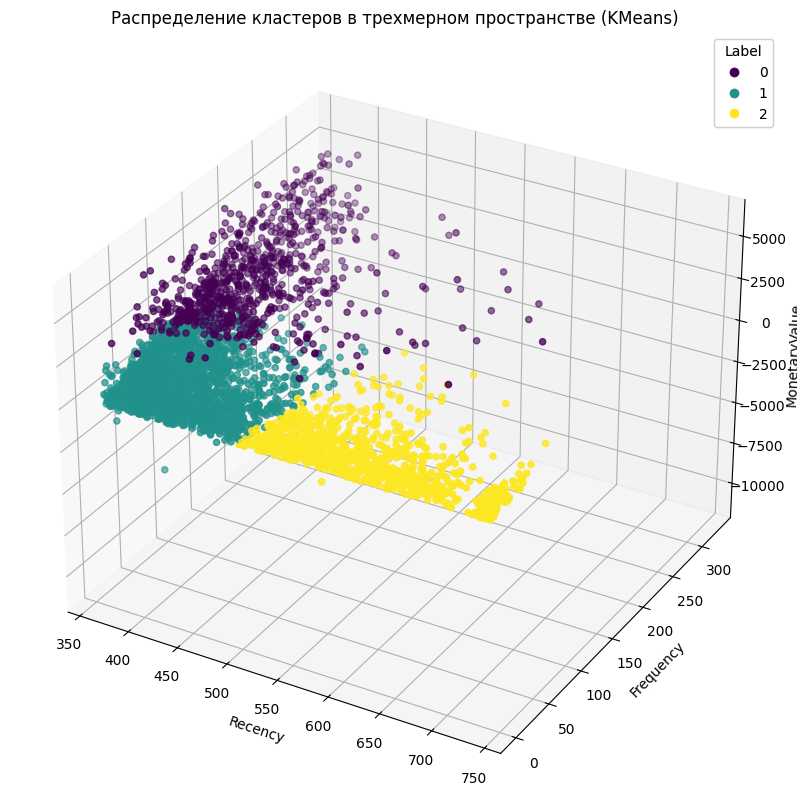

In [128]:
make_scatter3d(RFM_data, 'KMeans')

Кластер 0 - не более чем 100 заказов, не ранее 130 дней назад и не дороже 2000  - КЛАСС небогатых, которые недавно оказались у нас
Кластер 1 - разное количество заказов более 130 дней назад на сумму до 1000  - условные КЛАСС небогатых, которые пассивны.
Кластер 2 - более 100 заказов на сумму более 2000  в разное время - условные КЛАСС богатых , которые часто покупают .

C:\Users\DS\AppData\Local\Temp\ipykernel_18688\1759681457.py:37: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


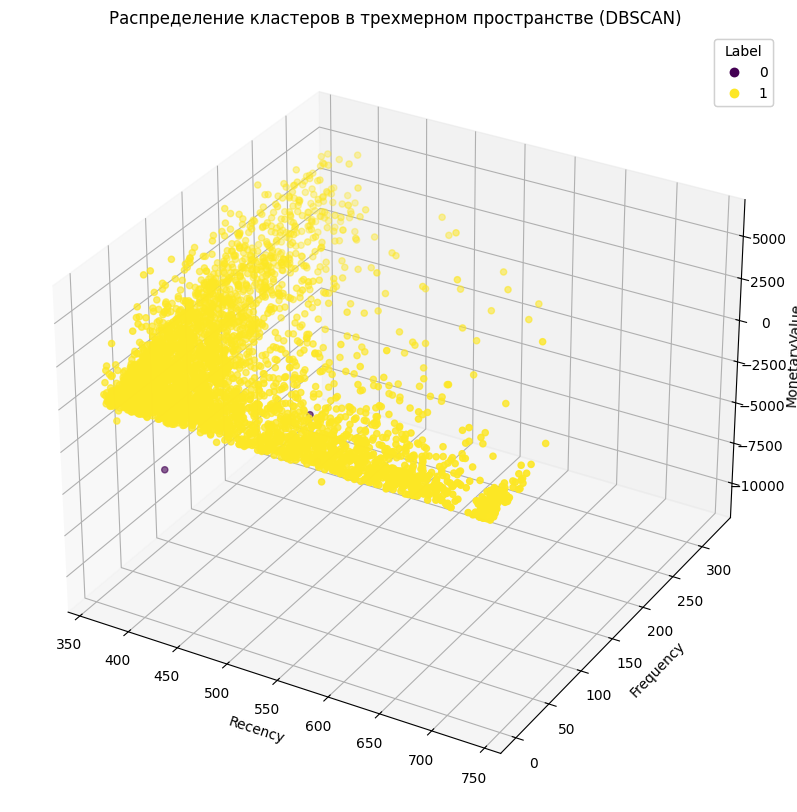

In [129]:
make_scatter3d(RFM_data, 'DBSCAN')

**DB-scan не справился со своей задачей в данном случае, факт**

## Иллюстрация профилей классов

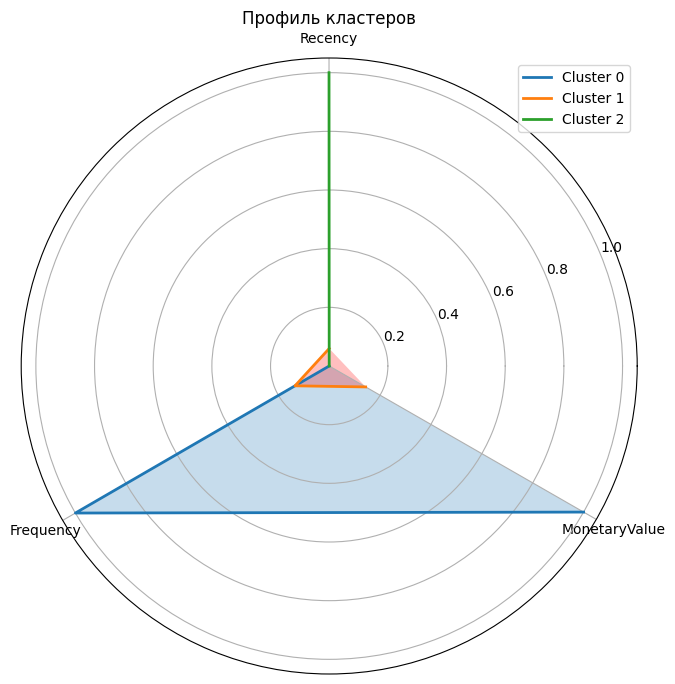

In [131]:

from sklearn.preprocessing import MinMaxScaler
fig = plt.figure(figsize=(8, 8))
ax = plt.subplot(polar=True)

pi = 22/7
angles = [pi/2, 7*pi/6, 11*pi/6]
plt.xticks(angles, cols)

# Группируем данные по кластерам и вычисляем среднее по RFM-признакам
RFM_groupped = RFM_data.groupby('Label_KMeans', as_index=False)[cols].mean()

# Нормализуем сгруппированные данные, приводя их к масштабу 0-1
scaler = MinMaxScaler()
RFM_scaled = pd.DataFrame(scaler.fit_transform(RFM_groupped), 
                          columns=RFM_groupped.columns)

# Строим 3 графика по трем кластерам
values = RFM_scaled[cols].iloc[0]
ax.plot(angles, values, linewidth=2, label='Cluster 0')
ax.fill(angles, values, 'p', alpha=0.25)

values = RFM_scaled[cols].iloc[1]
ax.plot(angles, values, linewidth=2, label='Cluster 1')
ax.fill(angles, values, 'r', alpha=0.25)

values = RFM_scaled[cols].iloc[2]
ax.plot(angles, values, linewidth=2, label='Cluster 2')
ax.fill(angles, values, 'b', alpha=0.25)

ax.set_title('Профиль кластеров')

# Выводим легенду и сам график
plt.legend()
plt.show()

**Класс новеньких бедных не незначительно влияют и по всем трем осям имеют одинаково малые показатели. 2 кластер не принес значительной прибыли магазину. А класс богатых и часто покупающих часто тратят деньги. И, соответственно существенно влияют**

Итак мы имееи 3 класса 
* Новенькие с малым достатком
* Бедные неактивные
* Богатые и часто покупающие